In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
'''!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip'''

Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [33]:
'''!ls /kaggle/working/'''
int(True)

1

In [34]:
import seaborn as sns

import fasttext
import json

def __flatten_child(trees):
    flat = []
    #flat.extend(map(lambda x: {"id": x["id"], "text": x["text"], "insult": int(x["insult"]), "not insult": int(not x["insult"])}, filter(lambda x: "insult"  in x, trees)))
    flat.extend(map(lambda x: {"id": x["id"], "text": x["text"], "insult": int(x["insult"])}, filter(lambda x: "insult"  in x, trees)))
    for obj in trees:
        if "children" in obj:
            flat.extend(__flatten_child(obj["children"]))
    return flat

def __flatten(trees):
    flat = []
    for root in trees:
        obj = root["root"]
        if "children" in obj:
            flat.extend(__flatten_child(obj["children"]))
    return flat

def __split_corp_label(labeled_discussions):
    corpus = []
    labels = []
    for obj in __flatten(labeled_discussions):
        if "insult" in obj:
            corpus.append({"id": obj["id"], "text": obj["text"]})
            #labels.append({"id": obj["id"], "insult": int(obj["insult"]), "not insult": int(not obj["insult"])})
            labels.append({"id": obj["id"], "insult": int(obj["insult"])})
    
    return corpus, labels

test_data = json.load(open("discussions_tpc_2015/modis/discussions.json", encoding="utf8"))
train_data = json.load(open("discussions_tpc_2015/students/discussions.json", encoding="utf8"))

train_df = pd.DataFrame.from_records(__flatten(train_data))

corpus, labels = __split_corp_label(test_data)
test_df = pd.DataFrame.from_records(corpus)
sample_submission_df = pd.DataFrame.from_records(labels)
test_labels_df = sample_submission_df

In [46]:
train_df.head()

,id,text,insult,labels
0,http://pavel_kosenko.livejournal.com/671121.ht...,первая обработанная вами фотка ну совсем не нр...,0,[]
1,http://pavel_kosenko.livejournal.com/671121.ht...,павел мне нравится,0,[]
2,http://pavel_kosenko.livejournal.com/671121.ht...,ухудшайзер соответствует названию за упражнен...,0,[]
3,http://pavel_kosenko.livejournal.com/671121.ht...,а может она только что из бани была,0,[]
4,http://pavel_kosenko.livejournal.com/671121.ht...,я в основном в чб редактирую фотографии ибо ц...,0,[]


In [4]:
sample_submission_df.head()

,id,insult
0,http://kruzenwtern.livejournal.com/373788.html...,False
1,http://kruzenwtern.livejournal.com/373788.html...,False
2,http://kruzenwtern.livejournal.com/373788.html...,False
3,http://kruzenwtern.livejournal.com/373788.html...,False
4,http://kruzenwtern.livejournal.com/373788.html...,False


In [5]:
test_df.head()

,id,text
0,http://kruzenwtern.livejournal.com/373788.html...,Познавательно))) Ушел смотреть свой пост с рул...
1,http://kruzenwtern.livejournal.com/373788.html...,Вместительная машина!
2,http://kruzenwtern.livejournal.com/373788.html...,"Извините, ребята, а как давно начали так пиари..."
3,http://kruzenwtern.livejournal.com/373788.html...,А что за каска такая симпатичная?
4,http://kruzenwtern.livejournal.com/373788.html...,"да, богатый на емкость сарай! :)"


In [36]:
import re
import logging
import itertools
import unicodedata
# import contractions

from bs4 import BeautifulSoup

class TextCleaningUtils:
    '''
        This class contains implementations of various text cleaning operations (Static Methods)
    '''


    cleaning_regex_map = {
        'web_links': r'(?i)(?:(?:http(?:s)?:)|(?:www\.))\S+',
        'special_chars': r'[^a-zA-Zа-яА-ЯёЁ0-9\s\.,!?;:]+',
        'redundant_spaces': r'\s\s+',
        'redundant_newlines': r'[\r|\n|\r\n]+',
        'twitter_handles': r'[#@]\S+',
        'punctuations': r'[\.,!?;:]+'
    }

    @staticmethod
    def clean_text_from_regex(text, text_clean_regex):
        '''
            Follow a particular cleaning expression, provided
            as an input by an user to clean the text.
        '''

        text = text_clean_regex.sub(' ', text).strip()
        return text

    @staticmethod
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    @staticmethod
    def remove_special_chars(text):
        '''
            Replace any special character provided as default,
            which is present in the text with space
        '''

        special_chars_regex = re.compile(TextCleaningUtils.cleaning_regex_map['special_chars'])
        text = TextCleaningUtils.clean_text_from_regex(text, special_chars_regex)
        return text

    @staticmethod
    def remove_redundant_spaces(text):
        '''
            Remove any redundant space provided as default,
            that is present in the text.
        '''

        redundant_spaces_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_spaces'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_spaces_regex)
        return text

    @staticmethod
    def remove_web_links(text):
        '''
            Removes any web link that follows a particular default expression,
            present in the text.
        '''

        web_links_regex = re.compile(TextCleaningUtils.cleaning_regex_map['web_links'])
        text = TextCleaningUtils.clean_text_from_regex(text, web_links_regex)
        return text

    @staticmethod
    def remove_twitter_handles(text):
        '''
            Removes any twitter handle present in the text.
        '''

        twitter_handles_regex = re.compile(TextCleaningUtils.cleaning_regex_map['twitter_handles'])
        text = TextCleaningUtils.clean_text_from_regex(text, twitter_handles_regex)
        return text

    @staticmethod
    def remove_redundant_newlines(text):
        '''
            Removes any redundant new line present in the text.
        '''

        redundant_newlines_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_newlines'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_newlines_regex)
        return text

    @staticmethod
    def remove_punctuations(text):
        '''
            Removes any punctuation that follows the default expression, in the text.
        '''

        remove_punctuations_regex = re.compile(TextCleaningUtils.cleaning_regex_map['punctuations'])
        text = TextCleaningUtils.clean_text_from_regex(text, remove_punctuations_regex)
        return text

    @staticmethod
    def remove_exaggerated_words(text):
        '''
            Removes any exaggerated word present in the text.
        '''

        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))

    @staticmethod
    def replace_multiple_chars(text):
        '''
            Replaces multiple characters present in the text.
        '''

        char_list = ['.', '?', '!', '#', '$', '/', '@', '*', '(', ')', '+']
        final_text = ''
        for i in char_list:
            if i in text:
                pattern = "\\" + i + '{2,}'
                repl_str = i.replace("\\", "")
                text = re.sub(pattern, repl_str, text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def replace_sign(text):
        '''
            Replaces any sign with words like & with 'and', in the text.
        '''
        sign_list = {'&': ' and ', '/': ' or ', '\xa0': ' '}
        final_text = ''
        for i in sign_list:
            if i in text:
                text = re.sub(i, sign_list[i], text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def remove_accented_char(text):
        text = unicodedata.normalize('NFD', text) \
            .encode('ascii', 'ignore') \
            .decode("utf-8")
        return str(text)

    @staticmethod
    def replace_characters(text, replace_map):
        '''
            Replaces any character custom provided by an user.
        '''

        for char, replace_val in replace_map.items():
            text = text.replace(char, replace_val)
        return text

In [37]:
def clean_data(df,col_to_clean):
  df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_special_chars)
  df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_spaces)
  df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_punctuations)
  df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_exaggerated_words)
  df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_newlines)
  df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_twitter_handles)
  df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_web_links)
  df[col_to_clean] = df[col_to_clean].astype(str)
  df[col_to_clean] = df[col_to_clean].str.lower()
  return df

In [38]:
train_df = clean_data(train_df,'text')

In [39]:
test_df = clean_data(test_df,'text')

In [45]:
def list_labels(row):
    label_list = []
    if row['insult'] == 1:
        label_list.append('insult')
    #if row['not insult'] == 1:
    #    label_list.append('not insult')
    return label_list
train_df['labels'] = train_df.apply(lambda x:list_labels(x) , axis=1)

In [17]:
# fwf converter

In [41]:
import logging
import pandas as pd
from ast import literal_eval
from tabulate import tabulate
import re


class FwfConvertor:

    def __init__(self):
        pass

    @staticmethod
    def save_fwf_tr_data(data, text_col, labels_col, label_mapping=None):
        if label_mapping is not None:
            data[labels_col] = data[labels_col].apply(FwfConvertor.label_map_func, label_mapping=label_mapping)
        # Preprocessing df in format for fwf
        data[labels_col] = data[labels_col].apply(FwfConvertor.preprocess_fwf_func)
        # limiting only two columns in fwf file
        data = data[[labels_col, text_col]]
        # Converting to fwf format
        content = FwfConvertor.to_fwf(data)
        try:
            open('Model Training data.train', 'w').write(content)
            logging.info("FWF file saved")
        except Exception as exp:
            logging.error("File saving failed", exp)

    @staticmethod
    def label_map_func(element, label_mapping):
        return list((tag.replace(tag, label_mapping[tag])) for tag in element)

    @staticmethod
    def preprocess_fwf_func(element):
        return " ".join(element)

    @staticmethod
    def to_fwf(df):
        content = tabulate(list(df.values), list(df.columns), tablefmt="plain")
        content = content[(content.find('\n') + 1):]
        content = re.sub(' +', ' ', content)
        return content

In [42]:
label_mapping = {"insult": "__label__ins"}

In [47]:
%%time
FwfConvertor.save_fwf_tr_data(train_df, 'text', 'labels', label_mapping=label_mapping)

Wall time: 3min 14s


In [18]:
# download wiki file
import fasttext.util
#fasttext.util.download_model('ru', if_exists='ignore')
%%time
ft = fasttext.load_model('fasttext/cc.ru.300.bin')

In [48]:
train_fn='Model Training data.train'
pretrainedvec_fn = 'fasttext/cc.ru.300.vec'

In [53]:
%%time
model = fasttext.train_supervised(input=train_fn,
                                  pretrainedVectors=pretrainedvec_fn,
                                  dim=300, 
                                  wordNgrams=2, 
                                  minCount=3, 
                                  epoch=25, 
                                  loss="ova")

Wall time: 9min 52s


In [54]:
train_df['debug_threshold'] = train_df['text'].apply(lambda x: model.predict(x,k=1))

In [55]:
train_df.head()

,id,text,insult,labels,debug_threshold
0,http://pavel_kosenko.livejournal.com/671121.ht...,первая обработанная вами фотка ну совсем не нр...,0,,"((__label__ins,), [1.0000100135803223])"
1,http://pavel_kosenko.livejournal.com/671121.ht...,павел мне нравится,0,,"((__label__ins,), [1.0000100135803223])"
2,http://pavel_kosenko.livejournal.com/671121.ht...,ухудшайзер соответствует названию за упражнен...,0,,"((__label__ins,), [0.9996300339698792])"
3,http://pavel_kosenko.livejournal.com/671121.ht...,а может она только что из бани была,0,,"((__label__ins,), [1.0000100135803223])"
4,http://pavel_kosenko.livejournal.com/671121.ht...,я в основном в чб редактирую фотографии ибо ц...,0,,"((__label__ins,), [0.998142421245575])"


In [56]:
model.predict("ты молодец",k=1)

(('__label__ins',), array([1.00001001]))

In [57]:
def get_proba(x,col):
    for label in range(len(x[0])):
        if label_mapping[col] == x[0][label]:
            return x[1][label]

In [58]:
for label in label_mapping.keys():
    train_df[label+'_predict']=train_df['text'].apply(lambda x: get_proba(model.predict(x,k=-1),label))
    sz = train_df[label+'_predict'].size-1
    train_df[label+'_sz'] = train_df[label+'_predict'].rank(method='max').apply(lambda x: 100.0*(x-1)/sz)

In [59]:
for label in label_mapping.keys():
    print(label,round(train_df[train_df[label]==1].shape[0]*100/train_df.shape[0],2),'%')
for label in label_mapping.keys():
    print(label,round(train_df[train_df[label+'_predict']==1].shape[0]*100/train_df.shape[0],2),'%')

insult 2.55 %
insult 0.0 %


In [24]:
train_df.columns

Index(['id', 'text', 'insult', 'labels', 'debug_threshold', 'insult_predict',
       'insult_sz', 'not insult_predict', 'not insult_sz'],
      dtype='object')

In [60]:
train_df.head(10)

,id,text,insult,labels,debug_threshold,insult_predict,insult_sz
0,http://pavel_kosenko.livejournal.com/671121.ht...,первая обработанная вами фотка ну совсем не нр...,0,,"((__label__ins,), [1.0000100135803223])",1.000010,100.000000
1,http://pavel_kosenko.livejournal.com/671121.ht...,павел мне нравится,0,,"((__label__ins,), [1.0000100135803223])",1.000010,100.000000
2,http://pavel_kosenko.livejournal.com/671121.ht...,ухудшайзер соответствует названию за упражнен...,0,,"((__label__ins,), [0.9996300339698792])",0.999630,47.082825
3,http://pavel_kosenko.livejournal.com/671121.ht...,а может она только что из бани была,0,,"((__label__ins,), [1.0000100135803223])",1.000010,100.000000
4,http://pavel_kosenko.livejournal.com/671121.ht...,я в основном в чб редактирую фотографии ибо ц...,0,,"((__label__ins,), [0.998142421245575])",0.998142,35.695304
5,http://pavel_kosenko.livejournal.com/671121.ht...,а правильное сканирование оно какое,0,,"((__label__ins,), [1.0000100135803223])",1.000010,100.000000
6,http://pavel_kosenko.livejournal.com/671121.ht...,тем кому не нравится первый пример достаточно...,0,,"((__label__ins,), [0.9967369437217712])",0.996737,31.102869
7,http://pavel_kosenko.livejournal.com/671121.ht...,вот мне интересно а если бы я делал отпечаток...,0,,"((__label__ins,), [0.9263137578964233])",0.926314,2.123073
8,http://pavel_kosenko.livejournal.com/671121.ht...,результат после плагина мне нравится в vsco с...,0,,"((__label__ins,), [0.9697954058647156])",0.969795,9.636782
9,http://pavel_kosenko.livejournal.com/671121.ht...,первая ок а вот на второй девушка после вашей...,0,,"((__label__ins,), [0.960371196269989])",0.960371,7.102792


In [61]:
train_df.describe()

,insult,insult_predict,insult_sz
count,207342.000000,207342.000000,207342.000000
mean,0.025533,0.991706,63.812561
std,0.157737,0.018489,39.161051
min,0.000000,0.749097,0.000482
25%,0.000000,0.993720,25.010008
50%,0.000000,1.000010,100.000000
75%,0.000000,1.000010,100.000000
max,1.000000,1.000010,100.000000


In [35]:
train_df[train_df['insult'] == 1].describe()

,insult,insult_predict,insult_sz
count,5294.0,5294.000000,5294.000000
mean,1.0,0.992457,63.763662
std,0.0,0.016755,38.036987
min,1.0,0.867046,0.140831
25%,1.0,0.994280,27.292721
50%,1.0,1.000010,100.000000
75%,1.0,1.000010,100.000000
max,1.0,1.000010,100.000000


In [36]:
test_df.head()

,id,text
0,http://kruzenwtern.livejournal.com/373788.html...,познавательно ушел смотреть свой пост с рулетк...
1,http://kruzenwtern.livejournal.com/373788.html...,вместительная машина
2,http://kruzenwtern.livejournal.com/373788.html...,извините ребята а как давно начали так пиари...
3,http://kruzenwtern.livejournal.com/373788.html...,а что за каска такая симпатичная
4,http://kruzenwtern.livejournal.com/373788.html...,да богатый на емкость сарай


In [27]:
train_df[train_df['insult']==0].describe([0.2,0.25,0.5,0.7,0.75,0.8,0.9,0.95,0.99])

,insult,not insult,insult_predict,insult_sz,not insult_predict,not insult_sz
count,16680.0,16680.0,16680.000000,16680.000000,16680.000000,16680.000000
mean,0.0,1.0,0.003432,61.378256,0.996498,62.482520
std,0.0,0.0,0.008098,16.913239,0.008330,38.490361
min,0.0,1.0,0.000010,48.054239,0.484390,0.011024
20%,0.0,1.0,0.000010,48.054239,0.994950,20.560026
25%,0.0,1.0,0.000010,48.054239,0.996527,25.515379
50%,0.0,1.0,0.000378,49.261382,0.999642,51.251240
70%,0.0,1.0,0.002262,69.446588,1.000010,100.000000
75%,0.0,1.0,0.003387,74.820858,1.000010,100.000000
80%,0.0,1.0,0.004915,79.699041,1.000010,100.000000


In [38]:
train_df[train_df['insult']==1].describe([0.05,0.1,0.2,0.25,0.5,0.7,0.75,0.8,0.9])

,insult,insult_predict,insult_sz
count,5294.0,5294.000000,5294.000000
mean,1.0,0.992457,63.763662
std,0.0,0.016755,38.036987
min,1.0,0.867046,0.140831
5%,1.0,0.953976,6.400567
10%,1.0,0.974053,11.938787
20%,1.0,0.990597,22.237763
25%,1.0,0.994280,27.292721
50%,1.0,1.000010,100.000000
70%,1.0,1.000010,100.000000


In [64]:
# threshold = {
#     'toxic_predict' : 0.970,
#     'severe_toxic_predict' : 0.27,
#     'obscene_predict': 0.69,
#     'threat_predict': 0.16,
#     'insult_predict':0.7,
#     'identity_hate_predict': 0.38
# }

threshold = {
    'insult_predict':0.98
}

In [65]:
def rescale_prob(x,label):
    min = 0
    max = 0.5
    if x < threshold[label]:
        normalized_x = (0.5 * (x - min))/(threshold[label] - min)
    else:
        normalized_x = 0.5 +(0.5 * (x - min))/(1 - min)
    return normalized_x

In [40]:
# x = 0.5
# min = 0
# max = 0.5
# 0.5 + (0.5 * (x - min))/(0.9 - min)

In [66]:
for label in label_mapping.keys():
    train_df[label+'_predict']=train_df['text'].apply(lambda x: get_proba(model.predict(x,k=-1),label))
    train_df[label+'_prob'] = train_df[label+'_predict'].apply(lambda x: rescale_prob(x,label+'_predict'))
    train_df[label+'_pred'] = train_df[label+'_predict'].apply(lambda x: 1 if x >= threshold[label+'_predict'] else 0)

In [42]:
# rescale_prob(0.5,'severe_toxic_predict')

In [47]:
# x=0.8
# min = 0
# max = 0.5
# (0.5 * (x - min))/(0.9 - min)

In [48]:
# x=0.8
# min = 0.5
# max = 1
# (0.5 * (x - min))/(0.8 - min)

In [67]:
for label in label_mapping.keys():
    test_df[label+'_predict']=test_df['text'].apply(lambda x: get_proba(model.predict(x,k=-1),label))
    test_df[label] = test_df[label+'_predict'].apply(lambda x: rescale_prob(x,label+'_predict'))

In [35]:
test_df[sample_submission_df.columns].to_csv('submission.csv',index=False,encoding='utf-8')
test_df.to_csv('all_cols_submission.csv', index=False,encoding='utf-8')

In [36]:
test_df.head()

,id,text,insult_predict,insult,not insult_predict,not insult
0,http://pavel_kosenko.livejournal.com/671121.ht...,первая обработанная вами фотка ну совсем не нр...,0.001042,0.000532,0.998945,0.999473
1,http://pavel_kosenko.livejournal.com/671121.ht...,павел мне нравится,0.000010,0.000005,1.000010,1.000005
2,http://pavel_kosenko.livejournal.com/671121.ht...,ухудшайзер соответствует названию за упражнен...,0.001294,0.000660,0.998685,0.999343
3,http://pavel_kosenko.livejournal.com/671121.ht...,а может она только что из бани была,0.000010,0.000005,1.000010,1.000005
4,http://pavel_kosenko.livejournal.com/671121.ht...,я в основном в чб редактирую фотографии ибо ц...,0.000529,0.000270,0.999474,0.999737


In [88]:
test_df.head()

,id,text,insult_predict,insult
0,http://pavel_kosenko.livejournal.com/671121.ht...,первая обработанная вами фотка ну совсем не нр...,0.999642,0.999821
1,http://pavel_kosenko.livejournal.com/671121.ht...,павел мне нравится,1.000010,1.000005
2,http://pavel_kosenko.livejournal.com/671121.ht...,ухудшайзер соответствует названию за упражнен...,0.999522,0.999761
3,http://pavel_kosenko.livejournal.com/671121.ht...,а может она только что из бани была,1.000010,1.000005
4,http://pavel_kosenko.livejournal.com/671121.ht...,я в основном в чб редактирую фотографии ибо ц...,0.997758,0.998879


In [53]:
# Confusion Matrix

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
def plot_cm(df,human_tag,pred_tag,tag,l1,l2):
  cm = confusion_matrix(df[human_tag], df[pred_tag])
  cm_df = pd.DataFrame(cm)
  plt.figure(figsize=(6,5))
  plt.title(tag)
  sns.heatmap(cm_df,annot=True,cmap="Blues",fmt="d",cbar=False)
  plt.xlabel(l1)
  plt.ylabel(l2)
  plt.show()

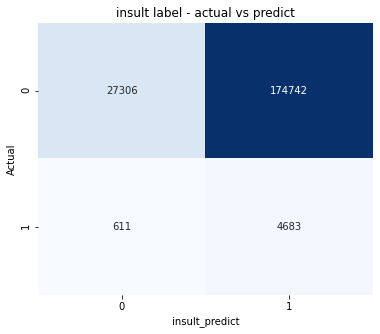

In [69]:
for tag in threshold.keys():
  actual_tag=tag.replace('_predict','')
  pred_tag=tag.replace('_predict','')+"_pred"
  plot_cm(train_df,actual_tag,pred_tag,actual_tag+' label - actual vs predict',tag,'Actual')

In [39]:
from sklearn.preprocessing import Binarizer
from sklearn.metrics import classification_report
for label in threshold.keys():
    actual_tag=label.replace('_predict','')
    y_test_label = np.where(train_df[actual_tag]==1, 1, 0)
    y_pred_temp = Binarizer(0.98).fit_transform(train_df[label].values.reshape(-1,1)) 
    score = classification_report(y_test_label, y_pred_temp)  
    print(score)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16680
           1       0.00      0.00      0.00      1463

    accuracy                           0.92     18143
   macro avg       0.46      0.50      0.48     18143
weighted avg       0.85      0.92      0.88     18143

              precision    recall  f1-score   support

           0       0.09      0.04      0.06      1463
           1       0.92      0.96      0.94     16680

    accuracy                           0.89     18143
   macro avg       0.50      0.50      0.50     18143
weighted avg       0.85      0.89      0.87     18143



In [57]:
# threshold = {
#     'toxic_predict' : 0.98,
#     'severe_toxic_predict' : 0.34,
#     'obscene_predict': 0.8,
#     'threat_predict': 0.36,
#     'insult_predict':0.76,
#     'identity_hate_predict': 0.6
# }



In [95]:
from sklearn.preprocessing import Binarizer
from sklearn.metrics import classification_report
for label in threshold.keys():
    actual_tag=label.replace('_predict','')
    y_test_label = np.where(sample_submission_df[actual_tag]==1, 1, 0)
    y_pred_temp = Binarizer(0.98).fit_transform(train_df[label].values.reshape(-1,1)) 
    score = classification_report(y_test_label, y_pred_temp)  
    print(score)

ValueError: Found input variables with inconsistent numbers of samples: [207342, 18143]

In [58]:

# train_df[label+'_pred'] = train_df[label+'_predict'].apply(lambda x: 1 if x >= threshold[label+'_predict'] else 0)
# for tag in threshold.keys():
#   actual_tag=tag.replace('_predict','')
#   pred_tag=tag.replace('_predict','')+"_pred"
#   plot_cm(train_df,actual_tag,pred_tag,actual_tag+' label - actual vs predict',tag,'Actual')

In [59]:
# train_df.head()

In [60]:
# def list_actual(x):
#     actual_list = []
#     for label in label_mapping.keys(): 
#         actual_tag = label.replace('_predict','')
#         actual_list.append(x[actual_tag])
#     return actual_list
# train_df['actual_label'] = train_df.apply(list_actual,axis=1)

In [61]:
# train_df.head()

In [62]:
# temp_df = train_df[['toxic_predict','severe_toxic_predict','obscene_predict','threat_predict','insult_predict','identity_hate_predict','actual_label']]

In [63]:
# temp_df = temp_df.head(500)

In [64]:
# temp_df.head(10)

In [65]:
# def get_pred_thres_arr(row,label,t):
#     bin_arr=[]
#     temp_thres=threshold.copy()
#     temp_thres[label]=t
#     for tag in threshold.keys():
#         res=0
#         if row[tag]>=temp_thres[tag]:
#             res=1
#         bin_arr.append(res)
#     return bin_arr

In [66]:
# threshold

In [67]:
# %%time

# from sklearn.preprocessing import Binarizer
# from sklearn.preprocessing import MultiLabelBinarizer

# from sklearn.metrics import f1_score
# for label in threshold.keys(): 
#     actual_tag = label.replace('_predict','')
#     y_test_label = np.array(list(temp_df['actual_label'].values))
#     thresholds = np.arange(0.02, 1, 0.02)
#     t_opt = 0
#     score_max = 0
#     for t in thresholds:
#         temp_df['pred_thres_bin']=temp_df.apply(lambda x: get_pred_thres_arr(x,actual_tag,t),axis=1)
#         y_pred_temp= np.array(list(temp_df['pred_thres_bin'].values))
#         score = f1_score(y_test_label, y_pred_temp, average='weighted')  # f1 score
#         if (score > score_max):
#             score_max = score
#             t_opt = t
#     print("Class: ", label, "\t Threshold: ", t_opt)